In [73]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

In [74]:
# Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (500, 500))  # Resize for consistency
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    blur = cv2.GaussianBlur(gray, (5, 5), 0)  # Noise Reduction
    sharp = cv2.Laplacian(blur, cv2.CV_64F)  # Image Sharpening
    return image, gray, sharp


In [75]:
# Feature Extraction Function
def extract_features(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [12, 12, 12], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    return np.hstack([hist, hu_moments])

In [76]:
# Chi-Square Distance Function
def chi2(histA, histB, eps=1e-10):
    return 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

In [77]:
# Load Dataset
dataset_path = "images"
image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".jpg")]
query_image_path = "images/query.jpg"

In [78]:
### Sequential Computing ###

def index_images_sequential(image_paths):
    feature_db = {}
    for img_path in image_paths:
        image, _, _ = preprocess_image(img_path)
        features = extract_features(image)
        feature_db[img_path] = features
    return feature_db

def search_similar_images_sequential(query_path, feature_db):
    query_img, _, _ = preprocess_image(query_path)
    query_features = extract_features(query_img)
    distances = {img_path: chi2(query_features, features) for img_path, features in feature_db.items()}
    return sorted(distances.items(), key=lambda x: x[1])[:5]

start_seq = time.time()
feature_db_seq = index_images_sequential(image_paths)
retrieved_images_seq = search_similar_images_sequential(query_image_path, feature_db_seq)
end_seq = time.time()
seq_time = end_seq - start_seq
print(f"Sequential CBIR Time: {seq_time:.2f} seconds")

Sequential CBIR Time: 155.34 seconds


Sequential CBIR Time: 155.34 seconds


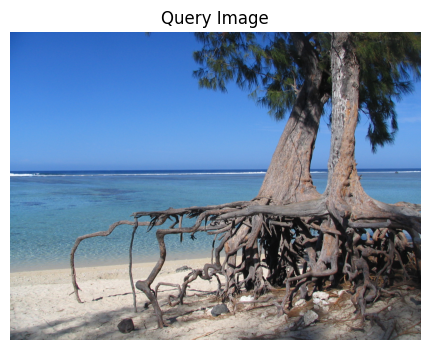

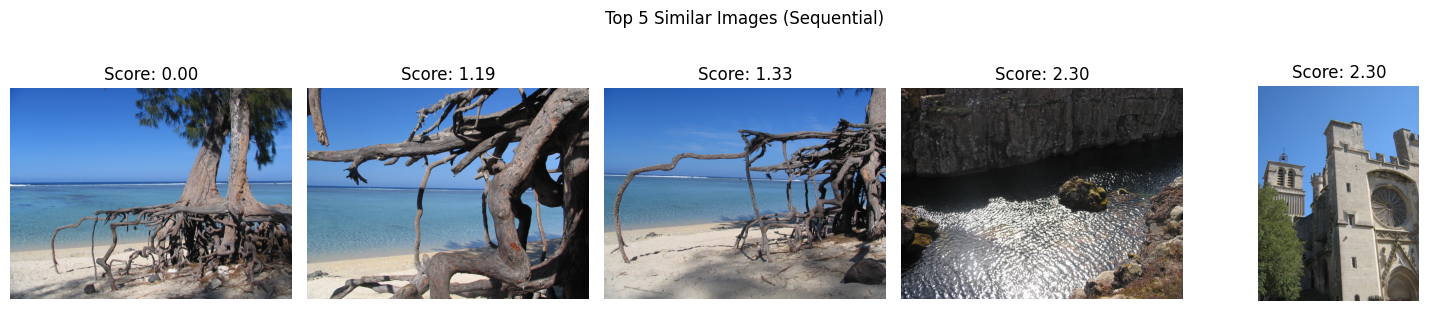

In [83]:

### Visualization of Results (Sequential) ###
print(f"Sequential CBIR Time: {seq_time:.2f} seconds")
query_img = cv2.imread(query_image_path)
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 4))
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display Top 5 Retrieved Images with Scores (Sequential)
plt.figure(figsize=(15, 3))
num_to_display = min(5, len(retrieved_images_seq))
for i, (img_path, score) in enumerate(retrieved_images_seq[:num_to_display]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"Score: {score:.2f}")
    plt.axis('off')
plt.suptitle("Top 5 Similar Images (Sequential)", y=1.02)
plt.tight_layout()
plt.show()

In [80]:
### Parallel Computing ###

def process_image(img_path):
    image, _, _ = preprocess_image(img_path)
    features = extract_features(image)
    return img_path, features

def index_images_parallel(image_paths):
    feature_db = {}
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, img_path) for img_path in image_paths]
        for future in as_completed(futures):
            img_path, features = future.result()
            feature_db[img_path] = features
    return feature_db

def compute_distance(query_features, img_path, features):
    return img_path, chi2(query_features, features)

def search_similar_images_parallel(query_path, feature_db):
    query_img, _, _ = preprocess_image(query_path)
    query_features = extract_features(query_img)
    distances = {}
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(compute_distance, query_features, img_path, features) for img_path, features in feature_db.items()]
        for future in as_completed(futures):
            img_path, distance = future.result()
            distances[img_path] = distance
    return sorted(distances.items(), key=lambda x: x[1])[:5]

start_par = time.time()
feature_db_par = index_images_parallel(image_paths)
retrieved_images_par = search_similar_images_parallel(query_image_path, feature_db_par)
end_par = time.time()
par_time = end_par - start_par

print(f"Parallel CBIR Time: {par_time:.2f} seconds")

Parallel CBIR Time: 12.71 seconds


Parallel CBIR Time: 12.71 seconds


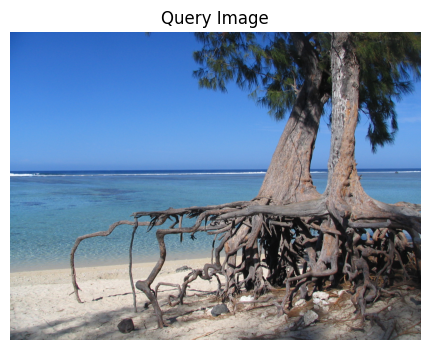

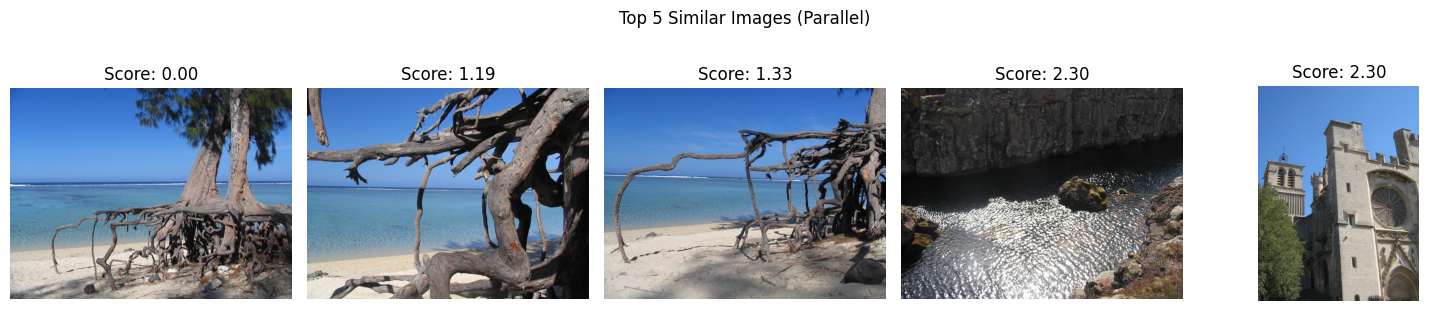

In [84]:

### Visualization of Results (Parallel) ###
print(f"Parallel CBIR Time: {par_time:.2f} seconds")
query_img_par = cv2.imread(query_image_path)
query_img_par = cv2.cvtColor(query_img_par, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 4))
plt.imshow(query_img_par)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display Top 5 Retrieved Images with Scores (Parallel)
plt.figure(figsize=(15, 3))
num_to_display_par = min(5, len(retrieved_images_par))
for i, (img_path, score) in enumerate(retrieved_images_par[:num_to_display_par]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, num_to_display_par, i + 1)
    plt.imshow(img)
    plt.title(f"Score: {score:.2f}")
    plt.axis('off')
plt.suptitle("Top 5 Similar Images (Parallel)", y=1.02)
plt.tight_layout()
plt.show()

In [82]:
### Speedup Calculation ###
speedup = seq_time / par_time
print(f"Speedup: {speedup:.2f}x")

Speedup: 12.22x


In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [52]:
def display(title_in, image_in, title_out, image_out, cmap_in=None, cmap_out=None):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_in, cmap=cmap_in)
    axes[0].set_title(title_in)
    axes[0].axis("off")

    axes[1].imshow(image_out, cmap=cmap_out)
    axes[1].set_title(title_out)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [65]:
Load the original image
image_path = "images/query.jpg"  # Ensure this is the correct path
original_image = None
if not os.path.exists(image_path):
    print(f"Error: The file '{image_path}' was not found!")
else:
    original_image = cv2.imread(image_path)
    if original_image is None:
        print("Error: OpenCV could not load the image.")
    else:
        rgb_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        


Input vs Output:


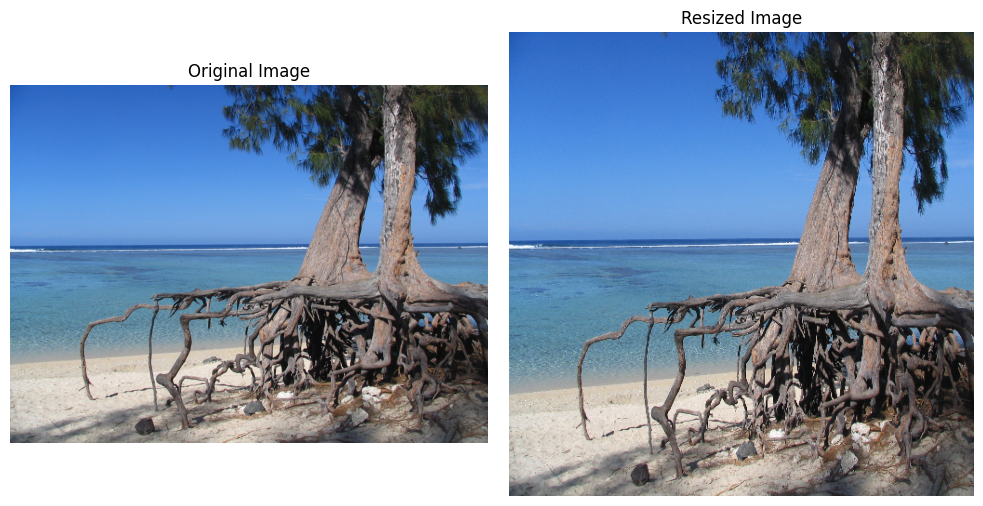

In [66]:
# Resize the image
if original_image is not None:
    resized_image = cv2.resize(original_image, (500, 500))
    rgb_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    rgb_resized = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    print("\nInput vs Output:")
    display("Original Image", rgb_original, "Resized Image", rgb_resized)


Input vs Output:


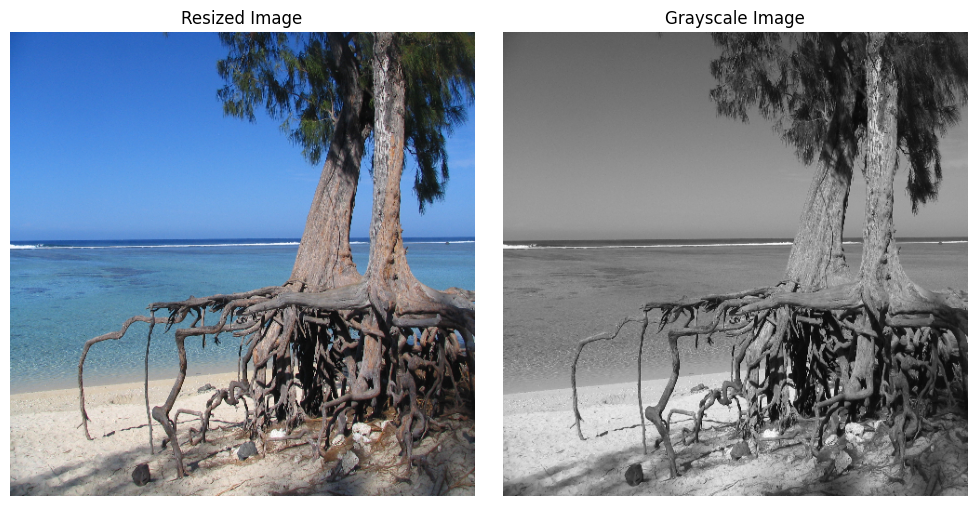

In [67]:
#  Convert the resized image to grayscale
if 'resized_image' in locals():
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    rgb_resized = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    print("\nInput vs Output:")
    display("Resized Image", rgb_resized, "Grayscale Image", gray_image, cmap_out='gray')


Input vs Output:


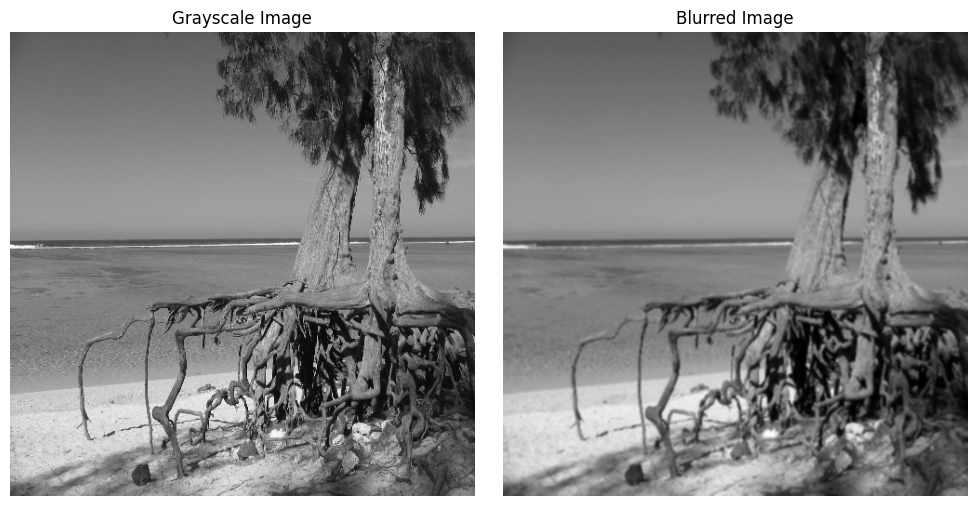

In [68]:
#  Apply Gaussian blur to the grayscale image
if 'gray_image' in locals():
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    print("\nInput vs Output:")
    display("Grayscale Image", gray_image, "Blurred Image", blurred_image, cmap_in='gray', cmap_out='gray')


Input vs Output:


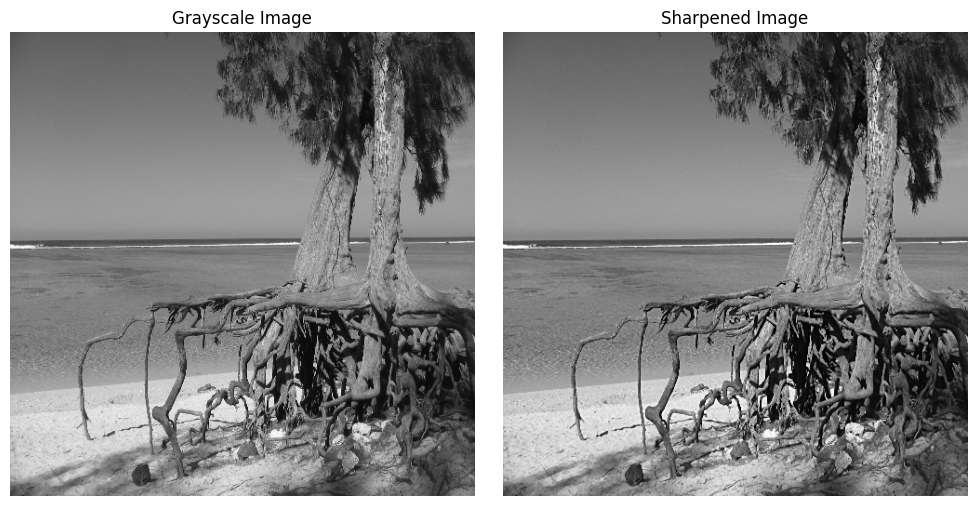

In [69]:
# Apply Laplacian sharpening
if 'gray_image' in locals() and 'blurred_image' in locals():
    laplacian = cv2.Laplacian(blurred_image, cv2.CV_64F)
    sharpened_image = cv2.subtract(gray_image.astype(np.float64), 0.5 * laplacian)
    sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)
    print("\nInput vs Output:")
    display("Grayscale Image", gray_image, "Sharpened Image", sharpened_image, cmap_in='gray', cmap_out='gray')

In [70]:
# Extract the color histogram (no direct image output)
if 'resized_image' in locals():
    def extract_color_histogram(image, bins=(12, 12, 12)):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    color_hist = extract_color_histogram(resized_image)
    rgb_resized = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    

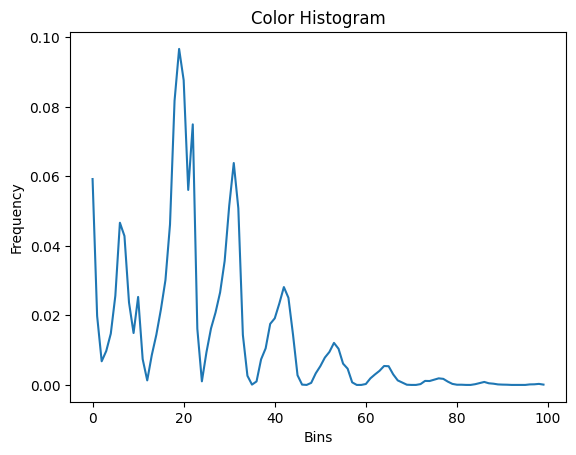

In [71]:
# Display the color histogram
if 'color_hist' in locals():
    plt.figure()
    plt.title("Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Frequency")
    plt.plot(color_hist[:100])  
    plt.show()

In [72]:
# Extract Hu Moments
if 'gray_image' in locals():
    def extract_hu_moments(image):
        moments = cv2.moments(image)
        hu_moments = cv2.HuMoments(moments).flatten()
        return -np.sign(hu_moments) * np.log10(np.abs(hu_moments))

    hu_moments = extract_hu_moments(gray_image)
    print("\nOutput: Hu Moments:", hu_moments)


Output: Hu Moments: [ 2.88156247  8.43503971 10.29492196 11.05178905 21.95152247 15.34317623
 21.81954781]
